# Denoising Diffusion Probabilistic Models
 📎 [Link to Paper](https://arxiv.org/abs/2006.11239)

## ✍️ Authors

Jonathaon Ho
Ajay Jain
Pieter Abbeel

## 📝 Abstract
We present high quality image synthesis results using diffusion probabilistic models,
a class of latent variable models inspired by considerations from nonequilibrium
thermodynamics. Our best results are obtained by training on a weighted variational
bound designed according to a novel connection between diffusion probabilistic
models and denoising score matching with Langevin dynamics, and our models nat-
urally admit a progressive lossy decompression scheme that can be interpreted as a
generalization of autoregressive decoding. On the unconditional CIFAR10 dataset,
we obtain an Inception score of 9.46 and a state-of-the-art FID score of 3.17. On
256x256 LSUN, we obtain sample quality similar to ProgressiveGAN. Our imple-
mentation is available at https://github.com/hojonathanho/diffusion.

## Difficulty
⚫⚫⚫⚫⚪

### 📦 Imports

In [2]:
from typing import Tuple, Optional
import torch
import torch.nn.functional as F
import torch.utils.data
from torch import nn
import torchvision
from torchvision import transforms
import numpy as np
from matplotlib import pyplot as plt

## Forward Diffusion

What distinguishes diffusion models from other types of latent variable models is that the approximate
posterior $q(x_{1:T} |x_0)$, called the forward process or diffusion process, is fixed to a Markov chain that
gradually adds Gaussian noise to the data according to a variance schedule $β_1, . . . , β_T$:
$$
p_\theta\left(\mathbf{x}_{0: T}\right):=p\left(\mathbf{x}_T\right) \prod_{t=1}^T p_\theta\left(\mathbf{x}_{t-1} \mid \mathbf{x}_t\right), \quad p_\theta\left(\mathbf{x}_{t-1} \mid \mathbf{x}_t\right):=\mathcal{N}\left(\mathbf{x}_{t-1} ; \boldsymbol{\mu}_\theta\left(\mathbf{x}_t, t\right), \boldsymbol{\Sigma}_\theta\left(\mathbf{x}_t, t\right)\right)
$$

In [3]:
beta = torch.linspace(0.0001, 0.02, 1000)
alpha = 1 - beta
alpha_bar = alpha.cumprod(0)

Let's have a look at the first and last alpha_bar values

In [4]:
alpha_bar[0], alpha_bar[-1]

(tensor(0.9999), tensor(4.0358e-05))

We see that `alpha_bar[0]` is very close to `1` and the last alpha `alpha_bar[-1]` is very close to `0`.

The paper provides a formular to sample the noise at an arbitrary timestep `t` which is defined as follows:

$q\left(\mathbf{x}_t \mid \mathbf{x}_0\right)=\mathcal{N}\left(\mathbf{x}_t ; \sqrt{\bar{\alpha}_t} \mathbf{x}_0,\left(1-\bar{\alpha}_t\right) \mathbf{I}\right)$

If $\bar{\alpha}_t$ is `1`, then the mean of the Normal Distribution is equal to $x_0$ as $\sqrt{1}=1$ and $1 * x_0 = x_0$. The covariance matrix gets multiplied by $1-\bar{\alpha}_t = 1 - 1 = 0$. Meaning that there is no variance at all.

Accordingly, if $\bar{\alpha}_t$ is `0`. We get a mean of `0` and a variance of `1` which is pure standard normal noise.

In [5]:
image_path = "./image.jpg"

# Read the image from file
x0 = torchvision.io.read_image(image_path)
x0.max(), x0.min()

(tensor(255, dtype=torch.uint8), tensor(0, dtype=torch.uint8))

In [6]:
x0 = x0.float() / 255.0

We define a function `show_image` that can show one or several images

In [7]:
def show_image(image, figsize=None, title=None):
    if len(image.shape) >= 4:
        n_images = image.shape[0]
        _, axes = plt.subplots(1, n_images, figsize=figsize)
        for ax, im in zip(axes, image):
            ax.imshow(im.permute(1, 2, 0))

    if len(image.shape) == 3:
        _, axes = plt.subplots(1, 1, figsize=figsize)
        axes.imshow(image.permute(1, 2, 0))
    

In [13]:
def show_image(image, figsize=None, title=None):

    if image[0] == 1:
        image.squeeze(0)
        _, axes = plt.subplots(1, 1, figsize=figsize)
        axes.imshow(image.permute(1, 2, 0))


    if len(image.shape) >= 4:
        n_images = image.shape[0]
        _, axes = plt.subplots(1, n_images, figsize=figsize)
        for ax, im in zip(axes, image):
            ax.imshow(im.permute(1, 2, 0))    

Let's see how the image looks with added noise for 100 timesteps

In [14]:
t = 100 
alpha_bar_t = alpha_bar[t].reshape(-1, 1, 1, 1)
noise = torch.randn_like(x0)

In [15]:
xt = alpha_bar_t.sqrt() * x0 + (1-alpha_bar_t).sqrt() * torch.randn_like(x0); xt.shape

torch.Size([1, 3, 512, 512])

As the shape if the image is `[1, 3, 512, 512]` we need to squeeze the first dimensions (batch dimension).

In [16]:
show_image(xt)

RuntimeError: Boolean value of Tensor with more than one value is ambiguous

Let's breake up the two parts of the above equation and have a look how they behave at different timesteps

In [71]:
mean = (alpha_bar_t.sqrt() * x0).squeeze()
variance = ((1-alpha_bar_t).sqrt() * torch.randn_like(x0)).squeeze()

torch.Size([1, 3, 512, 512])

In [77]:
def visualize_timestep(x0, t):
    alpha_bar_t = alpha_bar[t].reshape(-1, 1, 1, 1)
    mean = (alpha_bar_t.sqrt() * x0).squeeze()
    variance = ((1-alpha_bar_t).sqrt() * torch.randn_like(x0)).squeeze()
    xt = mean + variance
    show_image(torch.stack((mean, variance, xt.squeeze())), figsize=(16, 16)) # 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


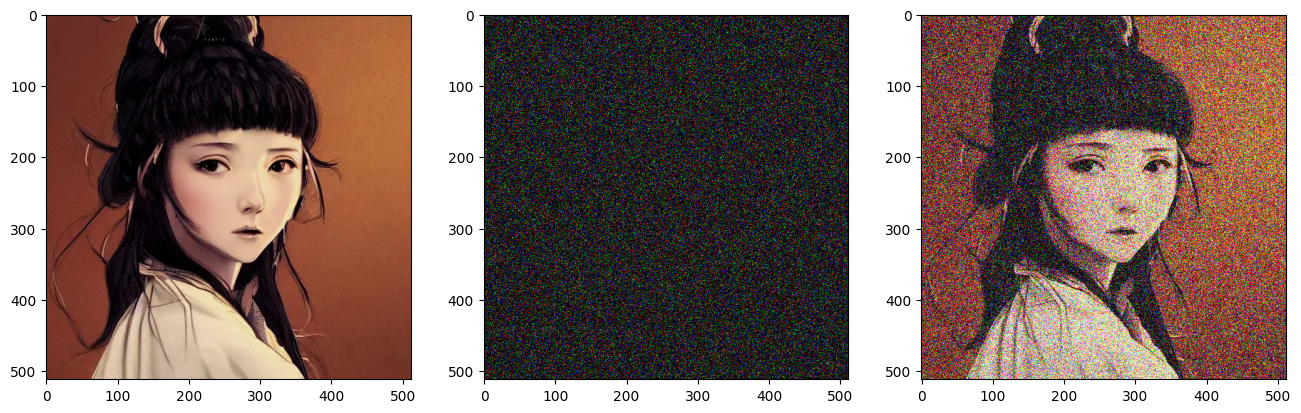

In [79]:
visualize_timestep(x0, 100)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


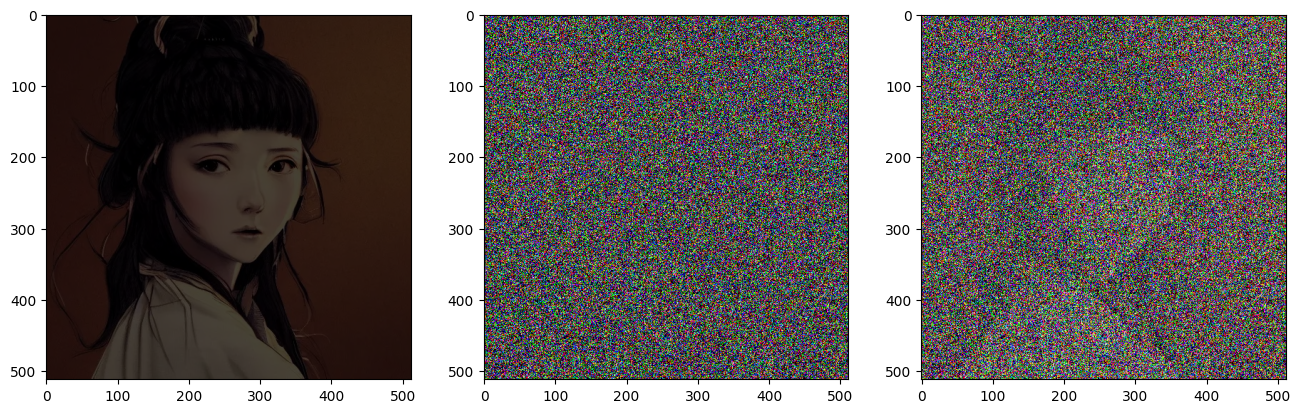

In [81]:
visualize_timestep(x0, 500)

Let's create a function that takes in an image `x` and a timestep `t` that adds noise to the image.

In [16]:
def add_noise(x0, t):
    noise = torch.randn_like(x0)
    alpha_bar_t = alpha_bar[t].reshape(-1, 1, 1, 1)
    return alpha_bar_t.sqrt() * x0 + (1-alpha_bar_t).sqrt() * noise